In [1]:
import pandas as pd # dataframe manipulation
import numpy as np # linear algebra

# data visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import shap

# sklearn 
from sklearn.cluster import KMeans
from sklearn.preprocessing import PowerTransformer, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, silhouette_samples, accuracy_score, classification_report

from pyod.models.ecod import ECOD
from yellowbrick.cluster import KElbowVisualizer

import lightgbm as lgb
import prince

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
def get_pca_2d(df, predict):
    pca_2d_object = prince.PCA(
    n_components=2,
    n_iter=3,
    rescale_with_mean=True,
    rescale_with_std=True,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
    )

    pca_2d_object.fit(df)

    df_pca_2d = pca_2d_object.transform(df)
    df_pca_2d.columns = ["comp1", "comp2"]
    df_pca_2d["cluster"] = predict

    return pca_2d_object, df_pca_2d



def get_pca_3d(df, predict):
    pca_3d_object = prince.PCA(
        n_components=3,
        n_iter=3,
        rescale_with_mean=True,
        rescale_with_std=True,
        copy=True,
        check_input=True,
        engine='sklearn',
        random_state=42
    )

    pca_3d_object.fit(df)

    df_pca_3d = pca_3d_object.transform(df)
    df_pca_3d.columns = ["comp1", "comp2", "comp3"]
    df_pca_3d["cluster"] = predict

    return pca_3d_object, df_pca_3d



def plot_pca_3d(df, title = "PCA Space", opacity=0.8, width_line = 0.1):

    df = df.astype({"cluster": "object"})
    df = df.sort_values("cluster")

    fig = px.scatter_3d(df, 
                        x='comp1', 
                        y='comp2', 
                        z='comp3',
                        color='cluster',
                        template="plotly",
                        
                        # symbol = "cluster",
                        
                        color_discrete_sequence=px.colors.qualitative.Vivid,
                        title=title).update_traces(
                            # mode = 'markers',
                            marker={
                                "size": 4,
                                "opacity": opacity,
                                # "symbol" : "diamond",
                                "line": {
                                    "width": width_line,
                                    "color": "black",
                                }
                            }
                        ).update_layout(
                                width = 1000, 
                                height = 800, 
                                autosize = False, 
                                showlegend = True,
                                legend=dict(title_font_family="Times New Roman",
                                            font=dict(size= 20)),
                                scene = dict(xaxis=dict(title = 'comp1', titlefont_color = 'black'),
                                            yaxis=dict(title = 'comp2', titlefont_color = 'black'),
                                            zaxis=dict(title = 'comp3', titlefont_color = 'black')),
                                font = dict(family = "Gilroy", color  = 'black', size = 15))
                      
    
    fig.show()


def plot_pca_2d(df, title = "PCA Space", opacity=0.8, width_line = 0.1):

    df = df.astype({"cluster": "object"})
    df = df.sort_values("cluster")

    fig = px.scatter(df, 
                        x='comp1', 
                        y='comp2', 
                        color='cluster',
                        template="plotly",
                        # symbol = "cluster",
                        
                        color_discrete_sequence=px.colors.qualitative.Vivid,
                        title=title).update_traces(
                            # mode = 'markers',
                            marker={
                                "size": 8,
                                "opacity": opacity,
                                # "symbol" : "diamond",
                                "line": {
                                    "width": width_line,
                                    "color": "black",
                                }
                            }
                        ).update_layout(
                                width = 800, 
                                height = 700, 
                                autosize = False, 
                                showlegend = True,
                                legend=dict(title_font_family="Times New Roman",
                                            font=dict(size= 20)),
                                scene = dict(xaxis=dict(title = 'comp1', titlefont_color = 'black'),
                                            yaxis=dict(title = 'comp2', titlefont_color = 'black'),
                                            ),
                                font = dict(family = "Gilroy", color  = 'black', size = 15))
                        
        
    fig.show()


In [3]:
embedding_df = pd.read_csv('datasets/embeddings.csv')
rfm_df = pd.read_csv('datasets/rfm.csv')

In [4]:
embedding_df

,0,1,2,3,4,5,6,7,8,9,...,375,376,377,378,379,380,381,382,383,384
0,00012a2ce6f8dcda20d059ce98491703,-0.041726,0.027510,-0.056882,-0.025510,-0.039508,0.034004,0.072638,0.022959,0.046100,...,0.043539,-0.057151,-0.025742,0.032607,-0.034897,-0.088789,0.072000,-0.103782,0.053510,-0.066814
1,000161a058600d5901f007fab4c27140,-0.025187,0.028512,-0.051201,-0.031295,-0.017220,0.034858,0.088030,-0.001838,0.025400,...,0.040438,-0.050716,-0.016604,0.021326,0.009126,-0.091526,0.068764,-0.090813,0.043563,-0.016957
2,0001fd6190edaaf884bcaf3d49edf079,-0.042614,-0.006086,-0.055272,-0.018040,-0.036303,0.000197,0.051186,-0.008452,0.008113,...,0.061899,-0.071525,-0.028327,0.032723,-0.047222,-0.062722,0.054100,-0.094184,-0.004905,-0.052936
3,0002414f95344307404f0ace7a26f1d5,-0.032341,0.025314,-0.052240,-0.033942,-0.015125,0.030855,0.080307,-0.007655,0.022211,...,0.048049,-0.061292,-0.018763,0.042044,-0.009364,-0.077682,0.059442,-0.095691,0.041043,-0.031703
4,000379cdec625522490c315e70c7a9fb,-0.043232,0.024513,-0.041906,-0.024336,-0.026824,0.017287,0.062362,0.008039,0.023804,...,0.043066,-0.054358,-0.026583,0.027596,-0.013308,-0.081860,0.072934,-0.085827,0.055174,-0.037855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98660,fffcb937e9dd47a13f05ecb8290f4d3e,-0.032689,0.025111,-0.048365,-0.033158,-0.021803,0.033321,0.083836,0.006141,0.027200,...,0.057138,-0.056611,-0.029213,0.031660,-0.018723,-0.092938,0.087352,-0.098558,0.055433,-0.023049
98661,fffecc9f79fd8c764f843e9951b11341,0.003677,0.020096,-0.047868,-0.032650,-0.057995,0.002792,0.074995,0.007019,0.040215,...,0.082177,-0.067597,-0.029806,0.005081,-0.018433,-0.059290,0.072124,-0.116688,0.020652,0.029288
98662,fffeda5b6d849fbd39689bb92087f431,-0.028621,0.039969,-0.055860,-0.024488,-0.049512,0.001517,0.058978,0.021212,0.036424,...,0.064900,-0.061066,-0.023392,0.032213,-0.016662,-0.079831,0.056698,-0.081857,0.021691,0.021796
98663,ffff42319e9b2d713724ae527742af25,-0.019088,0.018160,-0.045465,-0.031253,-0.007928,0.039723,0.073017,0.003020,0.033641,...,0.049041,-0.052159,-0.023299,0.042620,-0.006756,-0.079437,0.066008,-0.092598,0.037089,-0.036868


In [5]:
rfm_df

,customer_id,Recency,Frequency,MonetaryValue
0,00012a2ce6f8dcda20d059ce98491703,293,1,114.74
1,000161a058600d5901f007fab4c27140,414,1,67.41
2,0001fd6190edaaf884bcaf3d49edf079,552,1,195.42
3,0002414f95344307404f0ace7a26f1d5,383,1,179.35
4,000379cdec625522490c315e70c7a9fb,154,1,107.01
...,...,...,...,...
98660,fffcb937e9dd47a13f05ecb8290f4d3e,171,1,91.91
98661,fffecc9f79fd8c764f843e9951b11341,158,3,244.08
98662,fffeda5b6d849fbd39689bb92087f431,104,1,63.13
98663,ffff42319e9b2d713724ae527742af25,82,1,214.13


Outliers

In [6]:
from pyod.models.ecod import ECOD
# https://github.com/yzhao062/pyod

# Unsupervised Outlier Detection Using Empirical Cumulative Distribution Functions (ECOD)
clf = ECOD()
clf.fit(embedding_df.iloc[:, 1:])

out = clf.predict(embedding_df.iloc[:, 1:]) 
embedding_df["outliers"] = out
rfm_df["outliers"] = out

df_embedding_no_out = embedding_df[embedding_df["outliers"] == 0]
df_embedding_no_out = df_embedding_no_out.drop(["outliers"], axis = 1)

df_embedding_with_out = embedding_df.copy()
df_embedding_with_out = df_embedding_with_out.drop(["outliers"], axis = 1)

In [7]:
df_embedding_no_out.shape

(88798, 385)

In [8]:
df_embedding_with_out.shape

(98665, 385)

In [ ]:
# Instantiate the hierarchical clustering model and visualizer
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering()
visualizer = KElbowVisualizer(model, k=(2,12))

visualizer.fit(df_embedding_no_out.iloc[:, 1:])        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure




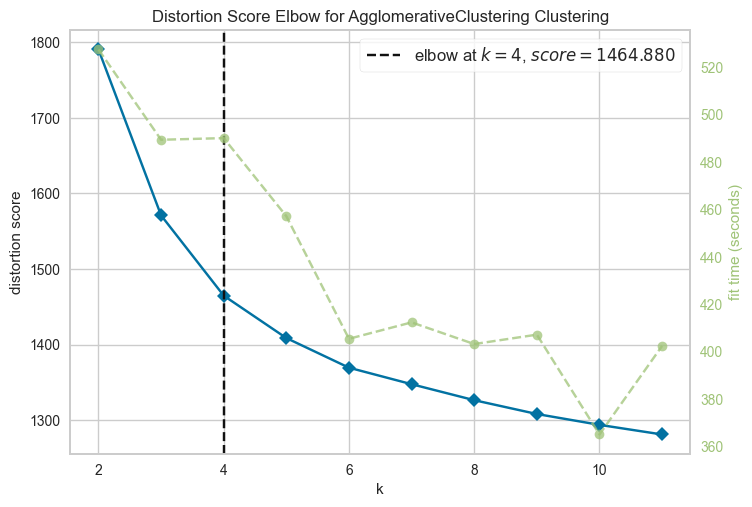

<Axes: title={'center': 'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>

In [9]:
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from yellowbrick.cluster import KElbowVisualizer
import numpy as np

# Step 1: Reduce dimensionality
pca = PCA(n_components=384)  # Adjust as needed
df_reduced = pca.fit_transform(df_embedding_no_out.iloc[:, 1:])

# Step 2: Sample your data
sample_size = 40000  # Adjust as needed
idx = np.random.choice(df_reduced.shape[0], sample_size, replace=False)
df_sample = df_reduced[idx]

# Step 3: Perform clustering on the sample
model = AgglomerativeClustering()
visualizer = KElbowVisualizer(model, k=(2,12))

visualizer.fit(df_sample)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [10]:
df_reduced.shape[0]

88798

In [ ]:
# Instantiate the hierarchical clustering model and visualizer
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from yellowbrick.cluster import KElbowVisualizer

model = AgglomerativeClustering()
visualizer = KElbowVisualizer(model, k=(2,12))

visualizer.fit(df_embedding_no_out.iloc[:, 1:])        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [ ]:
# Instantiate the hierarchical clustering model and visualizer
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from yellowbrick.cluster import KElbowVisualizer

model = AgglomerativeClustering()
visualizer = KElbowVisualizer(model, k=(2,12))

visualizer.fit(df_embedding_no_out.iloc[:, 1:])        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [ ]:
# Instantiate the hierarchical clustering model and visualizer
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from yellowbrick.cluster import KElbowVisualizer

model = AgglomerativeClustering()
visualizer = KElbowVisualizer(model, k=(2,12))

visualizer.fit(df_embedding_no_out.iloc[:, 1:])        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [ ]:
# def make_Silhouette_plot(X, n_clusters):
#     plt.xlim([-0.1, 1])
#     plt.ylim([0, len(X) + (n_clusters + 1) * 10])
#     clusterer = KMeans(n_clusters=n_clusters, max_iter = 1000, n_init = 10, init = 'k-means++', random_state=10)
#     cluster_labels = clusterer.fit_predict(X)
#     silhouette_avg = silhouette_score(X, cluster_labels)
#     print(
#         "For n_clusters =", n_clusters,
#         "The average silhouette_score is :", silhouette_avg,
#     )
# # Compute the silhouette scores for each sample
#     sample_silhouette_values = silhouette_samples(X, cluster_labels)
#     y_lower = 10
#     for i in range(n_clusters):
#         ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
#         ith_cluster_silhouette_values.sort()
#         size_cluster_i = ith_cluster_silhouette_values.shape[0]
#         y_upper = y_lower + size_cluster_i
#         color = cm.nipy_spectral(float(i) / n_clusters)
#         plt.fill_betweenx(
#             np.arange(y_lower, y_upper),
#             0,
#             ith_cluster_silhouette_values,
#             facecolor=color,
#             edgecolor=color,
#             alpha=0.7,
#         )
#         plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
#         y_lower = y_upper + 10
#         plt.title(f"The Silhouette Plot for n_cluster = {n_clusters}", fontsize=26)
#         plt.xlabel("The silhouette coefficient values", fontsize=24)
#         plt.ylabel("Cluster label", fontsize=24)
#         plt.axvline(x=silhouette_avg, color="red", linestyle="--")
#         plt.yticks([])  
#         plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
# range_n_clusters = list(range(2,10))
# for n_clusters in range_n_clusters:
#     print(f"N cluster: {n_clusters}")
#     make_Silhouette_plot(df_embedding_no_out, n_clusters)   
#     plt.savefig('Silhouette_plot_{}.png'.format(n_clusters))
#     plt.close()

In [ ]:
n_clusters = 3

In [ ]:
clusters = KMeans(n_clusters=n_clusters, init = "k-means++").fit(df_embedding_no_out.iloc[:, 1:])
print(clusters.inertia_)
clusters_predict = clusters.predict(df_embedding_no_out.iloc[:, 1:])

In [ ]:
clusters_predict

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

"""
The Davies Bouldin index is defined as the average similarity measure of each cluster with its most similar cluster, where similarity is the ratio of within-cluster distances to between-cluster distances.
The minimum value of the DB Index is 0, whereas a smaller value (closer to 0) represents a better model that produces better clusters.
"""
print(f"Davies bouldin score: {davies_bouldin_score(df_embedding_no_out.iloc[:, 1:],clusters_predict)}")

"""
Calinski Harabaz Index -> Variance Ratio Criterion.
Calinski Harabaz Index is defined as the ratio of the sum of between-cluster dispersion and of within-cluster dispersion.
The higher the index the more separable the clusters.
"""
print(f"Calinski Score: {calinski_harabasz_score(df_embedding_no_out.iloc[:, 1:],clusters_predict)}")


"""
The silhouette score is a metric used to calculate the goodness of fit of a clustering algorithm, but can also be used as a method for determining an optimal value of k (see here for more).
Its value ranges from -1 to 1.
A value of 0 indicates clusters are overlapping and either the data or the value of k is incorrect.
1 is the ideal value and indicates that clusters are very dense and nicely separated.
"""
print(f"Silhouette Score: {silhouette_score(df_embedding_no_out.iloc[:, 1:],clusters_predict)}")

In [ ]:
df_embedding_no_out

In [ ]:
# df_embedding_no_out = df_embedding_no_out.iloc[:, 1:]


In [ ]:
print(rfm_df.shape)
print(df_embedding_no_out.shape)

In [ ]:
# compare the two dataframes customer ids and remove the ones that are not in the df_embedding_no_out dataframe
print(rfm_df.shape)
print(df_embedding_no_out.shape)

rfm_df = rfm_df[rfm_df["customer_id"].isin(df_embedding_no_out['0'])]
print(rfm_df.shape)



In [ ]:
rfm_df["cluster"] = clusters_predict
rfm_df

In [ ]:
df_embedding_no_out

In [ ]:
rfm_df.drop(["outliers"], axis = 1, inplace = True)

In [ ]:
# plot the clusters in 3d
pca_3d_object, df_pca_3d = get_pca_3d(df_embedding_no_out.iloc[:, 1:], clusters_predict)
plot_pca_3d(df_pca_3d, title = "PCA Space with 3 Clusters", opacity=0.8, width_line = 0.1)

In [ ]:
# calculate silhouette score
silhouette_score(df_embedding_no_out.iloc[:, 1:], clusters_predict)

In [ ]:
rfm_df

In [ ]:
# import plotly.express as px

# # plot the clusters for rfm_df
# fig = px.scatter_3d(rfm_df,
#                     x = "Recency",
#                     y = "Frequency",
#                     z = "MonetaryValue",
#                     template="plotly",
#                     color_discrete_sequence=px.colors.qualitative.Vivid,
#                     title = "Clusters for RFM",
#                     opacity=0.8,
#                     width = 1000, 
#                     height = 800, 
#                     )
# fig.update_layout(showlegend=True,
#                   scene = dict(xaxis=dict(title = 'Recency', titlefont_color = 'black'),
#                                yaxis=dict(title = 'Frequency', titlefont_color = 'black'),
#                                zaxis=dict(title = 'MonetaryValue', titlefont_color = 'black')),
#                   font = dict(family = "Gilroy", color  = 'black', size = 15),
#                   autosize = False, 
#                   legend=dict(title_font_family="Times New Roman",
#                               font=dict(size= 20)))
# fig.show()


In [ ]:
# # calculate the silhouette score for the rfm_df
# silhouette_score(rfm_df.iloc[:, 1:-1], clusters_predict)

In [ ]:
# pca_3d_object, df_pca_3d = get_pca_3d(rfm_df.iloc[:, 1:], clusters_predict)
# plot_pca_3d(df_pca_3d, title = "PCA Space", opacity=1, width_line = 0.1)
# # %pip install nbformat
# print("The variability is :", pca_3d_object.eigenvalues_summary)

In [ ]:
# plot the clusters in 3d
df_pca_3d

In [ ]:
pca_2d_object, df_pca_2d = get_pca_2d(rfm_df.iloc[:, 1:], clusters_predict)
plot_pca_2d(df_pca_2d, title = "PCA Space", opacity=1, width_line = 0.2)


In [ ]:
sampling_data = df_embedding_no_out.sample(frac=0.5, replace=True, random_state=1)
sampling_clusters = pd.DataFrame(clusters_predict).sample(frac=0.5, replace=True, random_state=1)[0].values

df_tsne_3d = TSNE(
                  n_components=3, 
                  learning_rate=500, 
                  init='random', 
                  perplexity=200, 
                  n_iter = 5000).fit_transform(sampling_data.iloc[:, 1:])

df_tsne_3d = pd.DataFrame(df_tsne_3d, columns=["comp1", "comp2",'comp3'])
df_tsne_3d["cluster"] = sampling_clusters
plot_pca_3d(df_tsne_3d, title = "T-SNE Space", opacity=1, width_line = 0.1)

In [ ]:
plot_pca_3d(df_tsne_3d, title = "T-SNE Space", opacity=0.1, width_line = 0.1)

In [ ]:
df_tsne_2d = TSNE(
                  n_components=2, 
                  learning_rate=500, 
                  init='random', 
                  perplexity=200, 
                  n_iter = 5000).fit_transform(sampling_data)

df_tsne_2d = pd.DataFrame(df_tsne_2d, columns=["comp1", "comp2"])
df_tsne_2d["cluster"] = sampling_clusters

plot_pca_2d(df_tsne_2d, title = "PCA Space", opacity=0.5, width_line = 0.5)


In [ ]:
plot_pca_2d(df_tsne_2d, title = "PCA Space", opacity=1, width_line = 0.5)


In [ ]:
df_no_outliers = rfm_df[rfm_df["outliers"] == 0]
df_no_outliers = df_no_outliers.drop("outliers", axis = 1)

In [ ]:
import pandas as pd
import lightgbm as lgb
import shap

clf_km = lgb.LGBMClassifier(colsample_by_tree=0.8)

for col in ["Recency", "Frequency", "MonetaryValue"]:
    df_no_outliers[col] = df_no_outliers[col].astype('category')

clf_km.fit(X = df_no_outliers.iloc[:, 1:] , y = clusters_predict)

#SHAP values
explainer_km = shap.TreeExplainer(clf_km)
shap_values_km = explainer_km.shap_values(df_no_outliers)
shap.summary_plot(shap_values_km, df_no_outliers, plot_type="bar", plot_size=(15, 10))

In [ ]:
y_pred = clf_km.predict(df_no_outliers)
accuracy=accuracy_score(y_pred, clusters_predict)
print('Training-set accuracy score: {0:0.4f}'. format(accuracy))
print(classification_report(clusters_predict, y_pred))

In [ ]:
df_no_outliers["cluster"] = clusters_predict

df_group = df_no_outliers.groupby('cluster').agg(
    {
        'Recency': lambda x: x.value_counts().index[0],
        'Frequency': lambda x: x.value_counts().index[0],
        'Monetary Value': lambda x: x.value_counts().index[0]        
    }
).       sort_values("").reset_index()
df_group